In [65]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
import sys
from tqdm import tqdm
from functools import partial
import acd
from copy import deepcopy
sys.path.append('..')
sys.path.append('../..')
from transforms_torch import bandpass_filter
# plt.style.use('dark_background')
sys.path.append('../../dsets/mnist')
import dset
from model import Net, Net2c
from util import *
from numpy.fft import *
from torch import nn
from style import *
from captum.attr import (
    InputXGradient,
    Saliency,
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)
import pickle as pkl
from torchvision import datasets, transforms
from sklearn.decomposition import NMF
import transform_wrappers
import visualize as viz
from model import Net, Net2c
torch.manual_seed(42)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
from acd_wooseok.acd.scores import cd
from acd_wooseok.acd.util import tiling_2d
from acd_wooseok.acd.scores import score_funcs
from torchvision import datasets, transforms
# import modules
from funcs import *
from matfac import *
sys.path.append('../../..')
from hierarchical_dnn_interpretations.acd.scores import cd as acd

# Dataset

In [67]:
# load args
args = dset.get_args()
args.batch_size = int(args.batch_size/2) # half the batchsize
args.epochs = 50
args.cuda = not args.no_cuda and torch.cuda.is_available()

# load mnist dataloader
train_loader, test_loader = dset.load_data_with_indices(args.batch_size, args.test_batch_size, device)

# dataset
X = train_loader.dataset.data.numpy().astype(np.float32)
X = X.reshape(X.shape[0], -1)
X /= 255
Y = train_loader.dataset.targets.numpy()

X_test = test_loader.dataset.data.numpy().astype(np.float32)
X_test = X_test.reshape(X_test.shape[0], -1)
X_test /= 255
Y_test = test_loader.dataset.targets.numpy()

# load NMF object
# run NMF
# nmf = NMF(n_components=30, max_iter=1000)
# nmf.fit(X)
# pkl.dump(nmf, open('./results/nmf_30.pkl', 'wb'))
nmf = pkl.load(open('./results/nmf_30.pkl', 'rb'))
D = nmf.components_
# nmf transform
W = nmf.transform(X) 
W_test = nmf.transform(X_test) 

# Load model

In [94]:
def nmf_transform(W: np.array, data_indx, list_dict_indx=[0]):
    im_parts = W[data_indx][:,list_dict_indx] @ D[list_dict_indx] / 0.3081
    im_parts = torch.Tensor(im_parts).reshape(-1, 1, 28, 28)
    return im_parts

In [95]:
dict_indx = 1
model = Net2c().to(device)
model.load_state_dict(torch.load('models/nmf/net2c_{}.pth'.format(dict_indx), map_location=device))
model = model.eval()

# knockout first dictionary and redefine train and test dataset
indx = np.argwhere(W[:,dict_indx] > 0).flatten()
indx_t = np.argwhere(W_test[:,dict_indx] > 0).flatten()

# subset dataloader
train_loader, test_loader = dset.load_data_with_indices(args.batch_size,
                                                        args.test_batch_size,
                                                        device,
                                                        subset_index=[indx, indx_t])

## Saliency 

In [161]:
test_num = len(indx_t)

# true band centers model is trained with
scores_o = torch.zeros(test_num, nmf.n_components) # cd score for class 0 (original img)

# interp modules
saliency = Saliency(model)
ig = IntegratedGradients(model)

n = 0
for batch_indx, (data, target, data_indx) in enumerate(test_loader):
    batch_size = len(data)
    # eval mode
    model.eval()
    if args.cuda:
        model.cuda()  
        data = data.to(device).requires_grad_(True)
    # comp gradient
    attribution = saliency.attribute(data, target=0, abs=False)
#     attribution = ig.attribute(data, target=0)
    for comp_indx in range(nmf.n_components):
        im_parts = nmf_transform(W_test, data_indx, list_dict_indx=[comp_indx])
        score_o = torch.sum(attribution.cpu() * im_parts, axis=(1,2,3)).data
        scores_o[n:n+batch_size,comp_indx] = score_o
        
        print('\r batch index: {} [component index: {}]'.format(batch_indx, comp_indx), end='')  
    n += batch_size

 batch index: 3 [component index: 29]

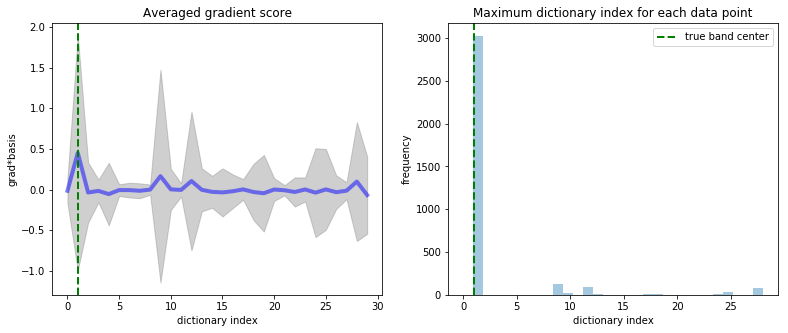

In [163]:
list_of_x = np.arange(nmf.n_components)
fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].plot(list_of_x, scores_o.mean(axis=0), alpha=0.5, color='blue', label='class(original)', linewidth=4.0)
ax[0].fill_between(list_of_x, scores_o.mean(axis=0)-scores_o.std(axis=0), 
                    scores_o.mean(axis=0)+scores_o.std(axis=0), color='#888888', alpha=0.4)
ax[0].axvline(x=dict_indx, linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[0].set_xlabel('dictionary index')
ax[0].set_ylabel('grad*basis')
ax[0].set_title('Averaged gradient score')
# ax[0].set_title('Test accuracy: {}/{} ({:.0f}%)'.format(accuracies[band_idx], 2*len(test_loader.dataset),
#         100. * accuracies[band_idx] / (2*len(test_loader.dataset))))
# ax[0].legend()

ax[1].hist(np.argmax(scores_o,axis=1), bins=30, alpha=0.4)
ax[1].axvline(x=dict_indx, linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[1].legend()
ax[1].set_xlabel('dictionary index')
ax[1].set_ylabel('frequency')
ax[1].set_title('Maximum dictionary index for each data point')
plt.show()

# Score NMF basis

In [44]:
# nmf transform layers
nmf_transformer = transform_wrappers.TransformLayers(D).to(device)

In [45]:
results = {
    'scores': [],
    'class_true': [],
    'class_pred': []
}
for i in range(10000):
    x = X_test[i: i + 1]
    x_t = nmf.transform(x)
    x_t_tensor = torch.Tensor(x_t).to(device)
    im = nmf_transformer.norm_reshape(torch.Tensor(x).to(device))

    sweep_dim = 1
    tiles = torch.Tensor(tiling_2d.gen_tiles(x_t, fill=0, method='cd', sweep_dim=sweep_dim)).to(device)
    cd_scores_im = []
    for j in range(30):  # can use tqdm here, need to use batches
        relevant = nmf_transformer(x_t_tensor * tiles[j])
        cd_scores_im.append(cd.cd(im, model, mask=None, model_type='mnist', device='cuda', transform=None,
                                 relevant=relevant)[0].data.cpu().numpy())
    cd_scores_im = np.squeeze(np.array(cd_scores_im))
    results['scores'].append(deepcopy(cd_scores_im))

    pred = model(deepcopy(im)).cpu().detach().numpy()
    results['class_pred'].append(np.argmax(pred))
    results['class_true'].append(Y_test[i])
    
    print('\riteration:', i, end='')

iteration: 9999

In [55]:
# pkl.dump(results, open(f'./results/nmf_scores.pkl', 'wb'))

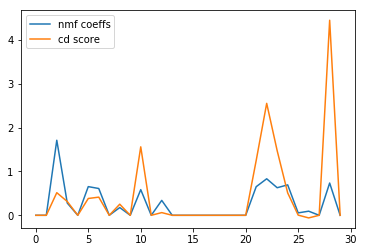

In [87]:
plt.plot(np.arange(nmf.n_components_), x_t.flatten()*10, label='nmf coeffs')
plt.plot(np.arange(nmf.n_components_), results['scores'][0][:,Y_test[i]], label='cd score')
plt.legend()
plt.show()